# Texas bridges data analysis

by **Bradley Aldous**

## Contents

 1. [Data Preparation](#first)
      1. [Loading and preparing the dataset](#1a)
      1. [Derivation of a new 'Age' variable](#1b)
      1. [Excluding old bridges](#1c)
      1. [Merging of small categories](#1d)
      1. [Deriving the current condition](#1e)
      1. [Dealing with missing values](#1f)
      1. [Exploring distributions of predictor variables](#1g)
      
 2. [Exploratory Analysis](#second)
      1. [Analysis of continuous predictors](#2a)
      1. [Analysis of categorical predictors](#2b)
      1. [Preliminary conclusions](#2c)
      
 3. [Regression Modelling](#third)
      1. [Linear regression and $R^2$](#3a)
      1. [Distribution of errors](#3b)
      1. [Comparing coefficients](#3c)
      1. [Final conclusions](#3d)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Part 1: Data Preparation <a class="anchor" id="first"></a>

The following analysis is exploring the effect of five predictor variables on the current condition of a bridge (the target variable). Our five predictors are:

 - 'Age': The age of the bridge (units of years)
 - 'AverageDaily': The average number of vehicles using the bridge in a day (units of vehicles per day)
 - 'Trucks_percent': The amount of trucks using the bridge as a percentage of the total number of vehicles (units of %)
 - 'Design_Merged': The type of design the bridge is built on (no units)
 - 'Material_Merged': The type of material the bridge is built out of (no units)

Our target variable 'CurrentCondition' has no units, and is just a number representing the overall condition the bridge is in (on a scale of 0 to 27).

In this section we prepare the dataset for further analysis by deriving new variables, merging categories and looking for outliers.

### A: Loading and preparing the dataset <a class="anchor" id="1a"></a>

The 'tx19_bridges_sample.csv' dataset is loaded and stored in the new dataframe 'Bridges'. A 'type map' is used to set the types of each variable, as well as explicitly setting an order for the ordinal variables.

In [2]:
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,Historic,Service_under,Material,Design,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,Not historic,Highway,Concrete,Beam,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,Not historic,Highway,Timber,Beam,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,Not historic,Highway,Concrete,Beam,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,Not historic,Railroad,Concrete,Beam,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,Not historic,Railroad,Concrete,Beam,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,Not historic,Highway,Concrete,Beam,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


### B: Deriving a new 'Age' variable <a class="anchor" id="1b"></a>

A new variable 'Age' is derived by subtracting the values in the column 'Year' from the current year (2021), and it is then assigned to our 'Bridges' data frame. This is a far easier concept to use in the following analyses than 'Year'.

In [3]:
bridges = bridges.assign(Age = 2021 - bridges['Year'])
bridges.describe()

,Detour_Km,Year,Lanes_on,Lanes_under,AverageDaily,Spans,Length,Width,Rated_load,Trucks_percent,Future_traffic,Age
count,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000
mean,10.860117,1981.497419,2.391450,1.688041,11628.005045,3.760505,92.805992,11.804794,29.763398,8.576561,16788.084857,39.502581
std,26.699284,23.860135,1.230033,3.729693,24230.771544,4.955459,187.107829,6.473383,5.291008,10.347291,35914.835568,23.860135
min,0.000000,1900.000000,1.000000,0.000000,0.000000,0.000000,6.100000,2.500000,0.000000,0.000000,0.000000,2.000000
25%,2.000000,1964.000000,2.000000,0.000000,330.000000,1.000000,24.400000,7.300000,24.500000,0.000000,440.000000,19.000000
50%,3.000000,1985.000000,2.000000,0.000000,3280.000000,3.000000,47.900000,11.000000,32.700000,5.000000,4600.000000,36.000000
75%,10.000000,2002.000000,2.000000,2.000000,11870.000000,4.000000,88.400000,13.400000,32.700000,13.000000,16820.000000,57.000000
max,999.000000,2019.000000,15.000000,99.000000,543000.000000,194.000000,6270.300000,228.000000,99.900000,99.000000,999999.000000,121.000000


### C: Excluding old bridges <a class="anchor" id="1c"></a>

In Texas, a bridge is defined as historic when it is *"rare in type, unusual from an engineering perspective, or historically significant because of its location or association with an important event or person"* (definition taken from http://onlinemanuals.txdot.gov/txdotmanuals/his/definition_and_identification.htm). Thus, using the historic variable seems like a simplistic and crude way to exclude old bridges, as it is possible that young bridges can be deemed historic and old ones can be deemed not historic. Looking at the table above, it is seen that the upper 25% of instances in 'Age' exist in the range 57 to 121 years (57 being less than half the age of the maximum value 121). So the bulk of the data is below 57 years, which is young in comparison to some of the bridges in the dataset, thus the third quartile is chosen as the cutoff in the following analysis (all data on bridges older than 57 years have been dropped).

In [4]:
bridges = bridges.drop(bridges[bridges.Age > 57].index)

### D: Merging of small categories <a class="anchor" id="1d"></a>

There are a large number of categories in the variables 'Design' and 'Material', some of which has very few instances in the dataset, thus it makes sense to combine these smaller categories into the 'Other' category. The pivot table below shows us that 'Beam' and 'Slab are far more frequent in the dataset than the other designs (by an order of magnitude of at least 2). So any designs that occur fewer than 100 times in the dataset are merged into the 'Other' category.

In [5]:
bridges_design_pt = bridges.pivot_table(values='Toll', index='Design', aggfunc='count')
bridges_design_pt

,Toll
Design,
Arch,82
Beam,23217
Frame,36
Movable,7
Other,1187
Slab,1648
Suspension,3
Truss,19


In [6]:
def design(row):
    if row.Design == 'Arch' or row.Design == 'Frame' or row.Design == 'Movable' or row.Design == 'Suspension' or row.Design == 'Truss':
        return 'Other'
    else:
        return row.Design

In [7]:
bridges = bridges.assign(Design_Merged = bridges.apply(design, axis=1))

The same logic has been applied to the 'Material' variable; in this case, just 'Masonry' has fewer than 100 instances in the dataset and so has been merged into the 'Other' category.

In [8]:
bridges_material_pt = bridges.pivot_table(values='Toll', index='Material', aggfunc='count')
bridges_material_pt

,Toll
Material,
Concrete,21184
Masonry,1
Other,39
Steel,4582
Timber,393


In [9]:
def material(row):
    if row.Material == 'Masonry':
        return 'Other'
    else:
        return row.Material

In [10]:
bridges = bridges.assign(Material_Merged = bridges.apply(material, axis=1))

### E: Deriving the current condition <a class="anchor" id="1e"></a>

The current condition is derived from the three variables; 'Deck_rating', 'Superstr_rating' and 'Substr_rating'. These are all ordinal variables, so the easiest way to arrive at a meaninful representation for the current condition is to assign an integer score to each rating (from 0 to 9). These converted scores are then stored in a new column called 'Deck_rating_score', 'Superstr_rating_score' and 'Substr_rating_score' for each respective rating.

In [11]:
score = {'Failed': 0, "Failing": 1, 'Critical': 2, 'Serious': 3, 'Poor': 4, 'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9}

In [12]:
bridges['Deck_rating_score'] = bridges['Deck_rating'].replace(score)
bridges['Superstr_rating_score'] = bridges['Superstr_rating'].replace(score)
bridges['Substr_rating_score'] = bridges['Substr_rating'].replace(score)
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,Historic,Service_under,Material,Design,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age,Design_Merged,Material_Merged,Deck_rating_score,Superstr_rating_score,Substr_rating_score
Structure_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,16,Slab,Concrete,7.0,8,8
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,16,Slab,Concrete,7.0,7,8
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,Not historic,Highway,Concrete,Beam,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,9,Beam,Concrete,8.0,8,8
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,Not historic,Highway,Concrete,Beam,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,17,Beam,Concrete,7.0,8,8
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,Not historic,Highway,Concrete,Beam,2,49.1,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,16,Beam,Concrete,8.0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,Not historic,Railroad,Concrete,Beam,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,27,Beam,Concrete,7.0,7,7
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,Not historic,Railroad,Concrete,Beam,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,21,Beam,Concrete,7.0,7,7
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,Not historic,Highway,Concrete,Beam,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,25,Beam,Concrete,7.0,7,7


These three scores are then summed for each row to obtain a value between 3 and 27, which are then stored in a new column called 'CurrentCondition'.

In [13]:
bridges['CurrentCondition'] = bridges['Deck_rating_score'] + bridges['Superstr_rating_score'] + bridges['Substr_rating_score']
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,Historic,Service_under,Material,Design,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age,Design_Merged,Material_Merged,Deck_rating_score,Superstr_rating_score,Substr_rating_score,CurrentCondition
Structure_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,16,Slab,Concrete,7.0,8,8,23.0
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,Not historic,Highway,Concrete,Slab,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,16,Slab,Concrete,7.0,7,8,22.0
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,Not historic,Highway,Concrete,Beam,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,9,Beam,Concrete,8.0,8,8,24.0
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,Not historic,Highway,Concrete,Beam,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,17,Beam,Concrete,7.0,8,8,23.0
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,Not historic,Highway,Concrete,Beam,2,49.1,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,16,Beam,Concrete,8.0,8,8,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,Not historic,Railroad,Concrete,Beam,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,27,Beam,Concrete,7.0,7,7,21.0
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,Not historic,Railroad,Concrete,Beam,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,21,Beam,Concrete,7.0,7,7,21.0
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,Not historic,Highway,Concrete,Beam,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,25,Beam,Concrete,7.0,7,7,21.0


### F: Dealing with missing values <a class="anchor" id="1f"></a>

The table below shows some important quantities when evaluating the data for outliers, like the quartiles, median and standard deviation. However, the 'count' value for 'Deck_rating_score' and 'CurrentCondition' is lower than all other variables by 5.

In [14]:
bridges.describe()

,Detour_Km,Year,Lanes_on,Lanes_under,AverageDaily,Spans,Length,Width,Rated_load,Trucks_percent,Future_traffic,Age,Deck_rating_score,Superstr_rating_score,Substr_rating_score,CurrentCondition
count,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26199.000000,26194.000000,26199.000000,26199.000000,26194.000000
mean,10.059124,1991.716249,2.431505,2.016069,12453.585671,3.579221,102.502496,12.149815,30.678030,7.638612,18149.682621,29.283751,6.953157,7.074507,6.748845,20.776361
std,27.241219,15.913961,1.276357,4.047037,24805.192391,5.097774,202.846945,6.787171,4.676686,10.002836,37384.057156,15.913961,0.674302,0.815309,0.773181,1.829772
min,0.000000,1964.000000,1.000000,0.000000,0.000000,0.000000,6.100000,2.500000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1978.000000,2.000000,0.000000,300.000000,1.000000,25.600000,7.600000,32.700000,0.000000,400.000000,15.000000,7.000000,7.000000,6.000000,20.000000
50%,2.000000,1992.000000,2.000000,0.000000,3870.000000,3.000000,53.300000,11.000000,32.700000,5.000000,5310.000000,29.000000,7.000000,7.000000,7.000000,21.000000
75%,8.000000,2006.000000,3.000000,3.000000,13330.000000,4.000000,93.900000,13.400000,32.700000,11.000000,19080.000000,43.000000,7.000000,8.000000,7.000000,22.000000
max,999.000000,2019.000000,12.000000,99.000000,543000.000000,194.000000,6270.300000,228.000000,99.900000,99.000000,999999.000000,57.000000,9.000000,9.000000,9.000000,27.000000


Conducting a count of missing values on the entire dataset yields a value of 15, meaning there is likely 5 missing values in 'Deck_rating', which have then been carried over into 'Deck_rating_score' and 'CurrentCondition' in the calculations above to make a total of 15 missing values.

In [15]:
bridges.isnull().sum().sum()

15

'Deck_rating' is an important quantity in calculating the current condition, so for the following analysis any rows with missing values have been dropped from the dataset. This has a negligible impact on the regression as it is only 5 bridges out of almost 30,000.

In [16]:
bridges = bridges.dropna()

### G: Exploring the distributions of predictor variables <a class="anchor" id="1g"></a>

We can explore the distributions of our continuous predictors ('Age', 'AverageDaily' and 'Trucks_percent') to aid us in identifying an removing outliers from the dataset. The table above showing us the quartiles, max and min is useful in exploring these variables. 'Age' has already been cut to remove old bridges from the dataset so we can move on to the other predictors.

From inspecting the above table, we can see that 'AverageDaily' seems to have an incredibly high maximum value (543,000). We can use a histogram to verify that this value seems out of place for the dataset which can be seen below. A value of 543,000 is vastly greater than the bulk of the data - the majority of which is well below 100,000.

array([[<AxesSubplot:title={'center':'AverageDaily'}>]], dtype=object)

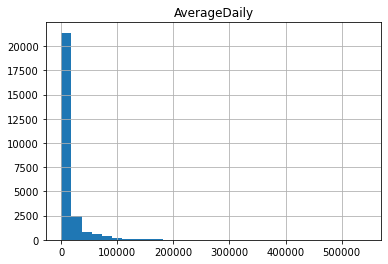

In [17]:
bridges.hist(column='AverageDaily', bins=30)

The below allows us to identify the 'Structure_id' of the particular bridge (102120348702012) with the maximum number of average uses. This bridge corresponds to the one described here: https://bridgereports.com/1533445, where it can be verified that the average daily traffic is the same as in the dataset, so it doesn't need to be dropped for the analysis. Thus no further constraints need to be put on 'AverageDaily'.

In [18]:
bridges.iloc[bridges['AverageDaily'].argmax()]

District                   District10
Detour_Km                           2
Toll                             Free
Maintainer                      State
Urban                           Urban
Status                          Minor
Year                             2009
Lanes_on                            3
Lanes_under                         2
AverageDaily                   543000
Historic                 Not historic
Service_under                 Highway
Material                     Concrete
Design                           Beam
Spans                               2
Length                          103.6
Width                            14.0
Deck_rating                      Good
Superstr_rating             Very Good
Substr_rating                    Good
Rated_load                       32.7
Trucks_percent                    3.0
Scour_rating              No waterway
Future_traffic                   7600
Age                                12
Design_Merged                    Beam
Material_Mer

The final continuous predictor to look at is 'Trucks_percent' which has a maximum value of 99%. It does seem extreme that 99% of vehicles crossing a bridge could be trucks (though not impossible), so this can be explored further using the same process as above. 

array([[<AxesSubplot:title={'center':'Trucks_percent'}>]], dtype=object)

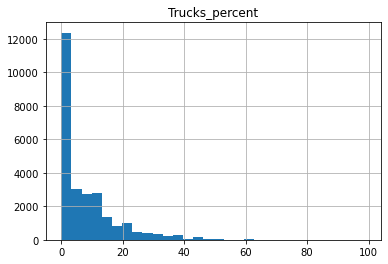

In [19]:
bridges.hist(column='Trucks_percent', bins=30)

This seems even more out of place from looking at the data below as it states this bridge is in an urban area. It seems a value like this could exist near a haulage depot in a city's outer limits as there would be almost no other traffic. Searching the 'Structure_id' gives this bridge: https://bridgereports.com/1565145. The percentage of truck traffic matches and it seems logical as this sits right on the Texas-Mexico border, meaning very few vehicles that aren't trucks will be crossing. Thus, the variable 'Trucks_percent' doesn't require any constraining.

In [20]:
bridges.iloc[bridges['Trucks_percent'].argmax()]

District                   District22
Detour_Km                          40
Toll                             Toll
Maintainer               Town or City
Urban                           Urban
Status                          Local
Year                             2000
Lanes_on                            8
Lanes_under                         0
AverageDaily                    13500
Historic                 Not historic
Service_under                 Highway
Material                     Concrete
Design                           Beam
Spans                              10
Length                          297.8
Width                            30.5
Deck_rating                      Good
Superstr_rating             Very Good
Substr_rating            Satisfactory
Rated_load                       32.7
Trucks_percent                   99.0
Scour_rating                      Dry
Future_traffic                  26500
Age                                21
Design_Merged                    Beam
Material_Mer

## Part 2: Exploratory Analysis <a class="anchor" id="second"></a>

In this section we explore the relationships between each of the five predictors and the target variable, looking for and trying to explain any correlations.

### A: Analysis of continuous predictors <a class="anchor" id="2a"></a>

A good way to visualise the relationship between continuous variables is through the use of scatter plots. The scatter plots below show the relations that 'CurrentCondition' has with the three continuous predictors; 'Age', 'AverageDaily' and 'Truck_percent'.

<AxesSubplot:xlabel='Trucks_percent', ylabel='CurrentCondition'>

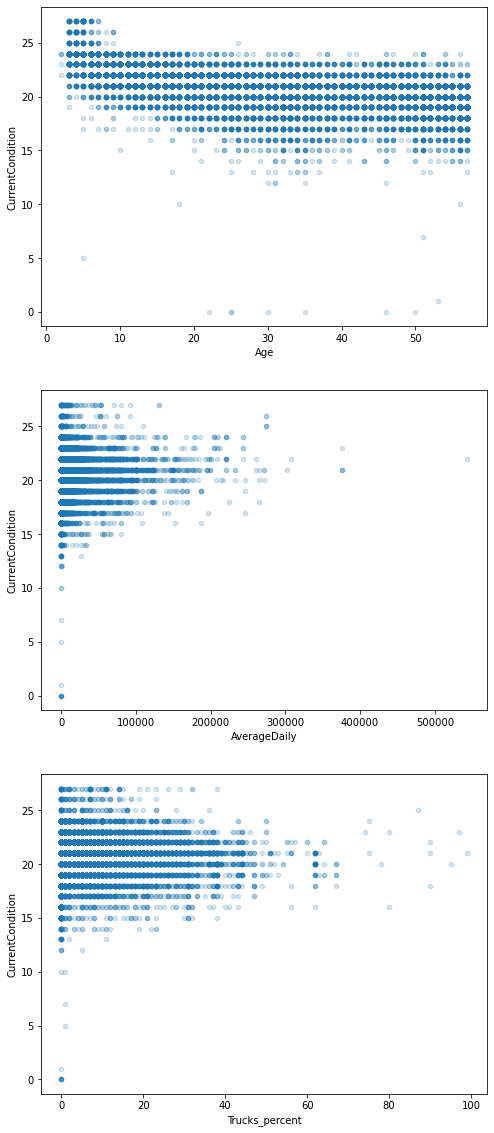

In [21]:
fig, (a1,a2,a3) = plt.subplots(3, 1, figsize=(8,20))
bridges.plot(kind='scatter',  x='Age', y='CurrentCondition', ax=a1, alpha=0.2)
bridges.plot(kind='scatter',  x='AverageDaily', y='CurrentCondition', ax=a2, alpha=0.2)
bridges.plot(kind='scatter',  x='Trucks_percent', y='CurrentCondition', ax=a3, alpha=0.2)

Studying the plots above leads one to believe that 'Age' is the most strongly correlated of these predictors with the target variable 'CurrentCondition', whilst it is difficult to draw a meaningful relationship from the other two plots. Our thoughts can be verified through the use of a heatmap, which tells us how correlated the target variable and predictors are with one another. To do this, a new data frame 'bridges_corr' has been created which is the same as 'bridges', except any variables that aren't of concern in our analysis have been dropped so that the heatmap below doesn't become cluttered with irrelevant data.

In [22]:
bridges_corr = bridges.drop(['District', 'Detour_Km', 'Maintainer', 'Urban', 'Status', 'Lanes_on', 'Lanes_under', 'Historic',
                             'Service_under', 'Spans', 'Length', 'Width', 'Rated_load', 'Scour_rating','Future_traffic',
                             'Deck_rating', 'Substr_rating', 'Superstr_rating', 'Deck_rating_score', 'Superstr_rating_score',
                             'Substr_rating_score', 'Year', 'Toll', 'Material', 'Design', 'Design_Merged', 'Material_Merged'], axis = 1)

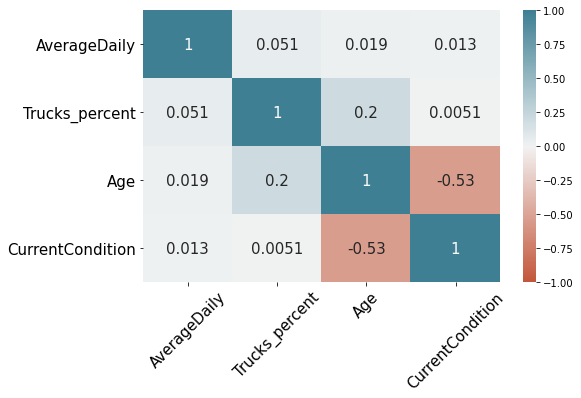

In [23]:
fig,ax = plt.subplots(1,1, figsize=(8,5))
sns.heatmap(bridges_corr.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

From the above we can that our thoughts on the correlations were true. A value of -0.53 for 'Age' and 'CurrentCondition' implies a fairly strong negative correlation. This makes logical sense as the older a bridge is, the more weathered it becomes and its condition deteriorates.

Surprisingly 'Age' and 'Trucks_percent' seem to have a slight positive correlation, which seems a bit strange on first glance. However, this is likely due to the fact that trucks tend to follow established routes (i.e. not with newly built bridges on), which could explain the correlation. All other relationships between the variables appear to have no or a negligible correlation.

### B: Analysis of categorical predictors <a class="anchor" id="2b"></a>

We can use cross-tabulation to look at and compare categorical predictors. Below we have tables representing probabilities; the first one being the joint probability of each design and material, the second and third tables being the conditional probabilities of each design and material.

In [24]:
des_and_mat = pd.crosstab(bridges.Design_Merged, [bridges.Material_Merged], normalize='all')

mat_given_des = pd.crosstab(bridges.Design_Merged, [bridges.Material_Merged], normalize='index')
des_given_mat = pd.crosstab(bridges.Material_Merged, [bridges.Design_Merged], normalize='index')

In [25]:
des_and_mat.round(4) * 100

Material_Merged,Concrete,Other,Steel,Timber
Design_Merged,,,,
Beam,70.85,0.00,16.28,1.5
Other,3.71,0.15,1.21,0.0
Slab,6.29,0.00,0.00,0.0


In [26]:
mat_given_des.round(4) * 100

Material_Merged,Concrete,Other,Steel,Timber
Design_Merged,,,,
Beam,79.94,0.00,18.37,1.69
Other,73.16,3.01,23.83,0.00
Slab,100.00,0.00,0.00,0.00


In [27]:
des_given_mat.round(4) * 100

Design_Merged,Beam,Other,Slab
Material_Merged,,,
Concrete,87.63,4.59,7.78
Other,0.00,100.00,0.00
Steel,93.08,6.92,0.00
Timber,100.00,0.00,0.00


To visualise this, I've plotted each table as a bar chart below. The conditional probability graphs have been stacked as each variable adds up to one, and it's easier to compare different materials and designs this way.

Text(0.5, 1.0, 'Probability of Design, given Material')

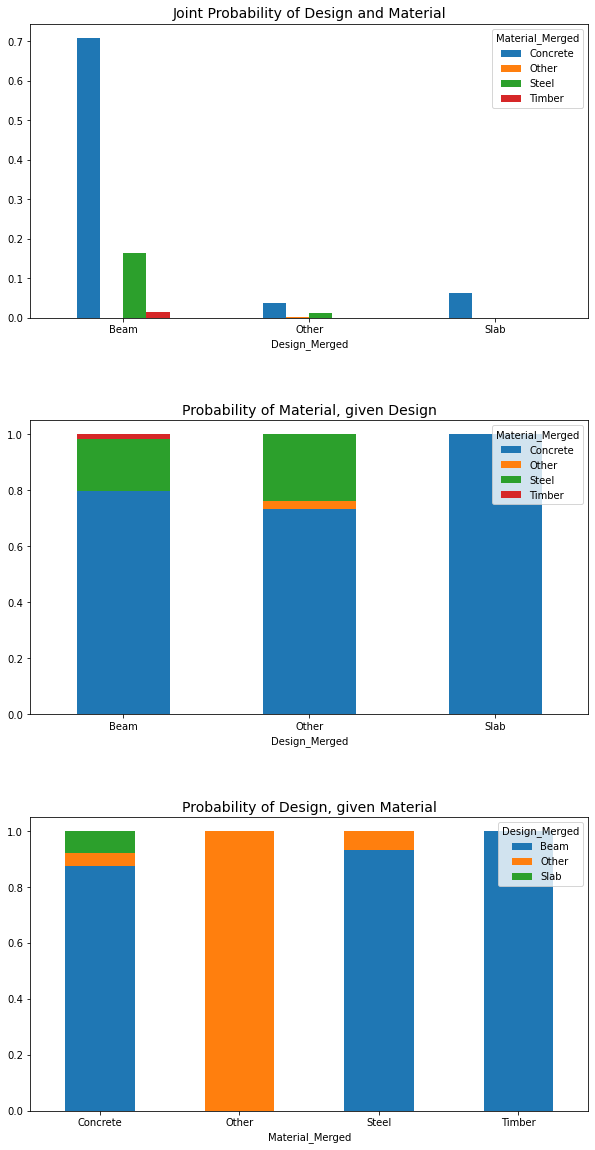

In [28]:
fig,(a1, a2, a3) = plt.subplots(3,1,figsize=(10,20), sharey=False, sharex=False)
fig.subplots_adjust(hspace=0.35)

des_and_mat.plot(kind='bar', subplots=False, ax=a1, rot=0)
a1.set_title('Joint Probability of Design and Material', fontsize=14)

mat_given_des.plot(kind='bar', subplots=False, ax=a2, rot=0, stacked=True)
a2.set_title('Probability of Material, given Design', fontsize=14)

des_given_mat.plot(kind='bar', subplots=False, ax=a3, rot=0, stacked=True)
a3.set_title('Probability of Design, given Material', fontsize=14)

We can see from the first bar chart (the one for joint probability), that 'Beam' and 'Concrete' are by far the most common design and material in the dataset, whilst there are only a few instances of all other types.

### C: Preliminary conclusions <a class="anchor" id="2c"></a>

From this exploratory analysis I can draw the following preliminary conclusions. 'Age' will most likely be the most impactful and important predictor in this model, whilst 'AverageDaily' and 'Trucks_percent' will have a much more negligible effect on the regression (possibly no noticeable effect.

I would also expect 'Concrete' and 'Slab' to be the most important design and material in predicting the condition of a bridge, as they are by far the most common. This is likely due to the fact that they are newer types of bridge construction and will be able to withstand weathering for a longer period of time.

## Part 3: Regression Modelling <a class="anchor" id="third"></a>

In this section we conduct a linear regression on the dataset, obtaining coefficient, $R^2$ and intercept values. We then use these values to discuss our conclusions and give suggestions for further analysis.

### A: Linear regression and finding $R^2$ <a class="anchor" id="3a"></a>

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In order to conduct the regression we must transform our categorical predictors using reference encoding. Applying this to the 'Design_Merged' predictor gives us 'Beam' as a reference, whilst 'Other' and 'Slab' are used in the regression as dummy variables. This method essentially creates a new variable for these categories and assigns a binary value (0 or 1) to it, describing whether or not a bridge is made using that particular design. The same method is also applied to the 'Material_Merged' variable, dropping 'Concrete' and creating dummy variables from 'Other', 'Steel' and 'Timber'.

In [30]:
Design_d = pd.get_dummies(bridges.Design_Merged, drop_first=True)
Design_d

,Other,Slab
Structure_id,,
000021521-00101,0,1
000021521-00181,0,1
000021521-TMP20,0,0
000021580-00092,0,0
000021580-00093,0,0
...,...,...
DAPFORHOO000012,0,0
DAPFORHOO000013,0,0
DAPFORHOO000015,0,0


In [31]:
Material_d = pd.get_dummies(bridges.Material_Merged, drop_first=True)
Material_d

,Other,Steel,Timber
Structure_id,,,
000021521-00101,0,0,0
000021521-00181,0,0,0
000021521-TMP20,0,0,0
000021580-00092,0,0,0
000021580-00093,0,0,0
...,...,...,...
DAPFORHOO000012,0,0,0
DAPFORHOO000013,0,0,0
DAPFORHOO000015,0,0,0


Before applying the regression we need to assign the target variable to 'y' and the predictor variables to 'X'. After doing this, we can apply the linear regression model to 'X' and 'y', allowing us to obtain values for the $R^2$ coefficient of determination and the intercept, both of which are printed below.

In [32]:
y = bridges.CurrentCondition
X = np.column_stack((bridges.Age, bridges.AverageDaily, bridges.Trucks_percent,
                     Design_d.Other, Design_d.Slab, Material_d.Other, Material_d.Steel, Material_d.Timber))

In [33]:
reg = LinearRegression().fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)

The R2 coefficient of determination is 0.440
The intercept is 22.9


The $R^2$ coefficient of determination is a statistical measure of fit that indicates how much variation of a target variable is explained by the predictor variables in a regression model; 100% meaning that all movements of a target variable are completely explained by movements in the predictors. There isn't a solid scale for $R^2$ to base how good a model is at predicting the target variable, as different fields seem to have different expectations of what constitutes a good $R^2$ value. However, a model with a value of 0.440 is generally considered to be at least moderately effective at explaining the relationship between predictors and a target, some scholars referring to a value in this range as substantial (https://journals.sagepub.com/doi/10.1177/014662168801200410).

We can look more deeply into the effect that each particular predictor has on the target variable by comparing and analysing the beta coefficients, this is done in a section below.

The intercept value of 22.9 represents the predicted value for the current condition of a bridge made using the material and design that were dropped when obtaining our dummy variables. In this case, a bridge made out of concrete and of a beam design. This is also the most common type of bridge in the dataset, likely due to the fact that this is a more modern style of bridge. Thus, this is also likely to be a good indicator for the average (mode) condition of a bridge in this dataset (among other averaging method: mean, median etc).

### B: Distribution of errors <a class="anchor" id="3b"></a>

A good way to visualise errors with continuous variable is through the use of a scatter plot, as outliers and variance can be easily identified, especially once the regression line has been plotted (as has been done below).

Text(0, 0.5, 'Actual Value')

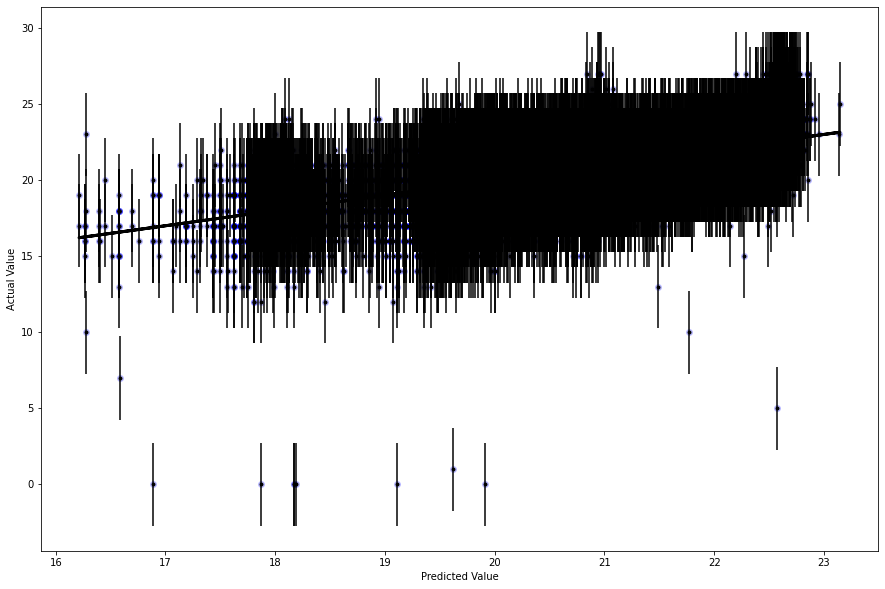

In [34]:
y_hat = reg.predict(X)
residuals = y_hat - y

fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='blue', alpha=0.2)
a.plot(y_hat, y_hat, color='black', linewidth=3)

two_std = residuals.std() * 2
a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

Text(0, 0.5, 'Actual Value')

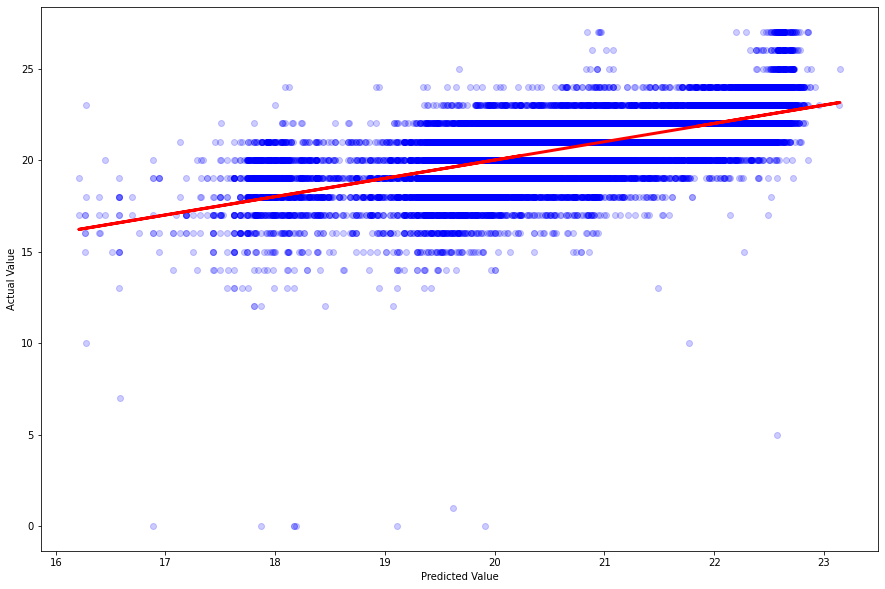

In [35]:
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='blue', alpha=0.2)
a.plot(y_hat, y_hat, color='red', linewidth=3)
a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

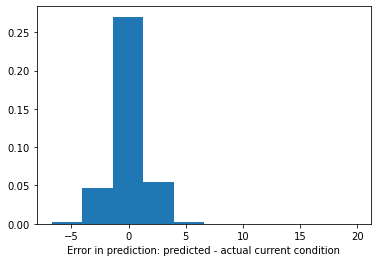

In [36]:
fig, a1 = plt.subplots(1, 1)
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

We can see there are roughly 10 data points that have such large errors that they appear to be outliers. However, these data points aren't actually incorrect, they just represent bridges that are in incredibly poor condition ('Failed' or 'Failing' in all three categories), thus they have significant errors due to the massively high volume of points (26,000+) that sit near to the regression line. Adding error bars to the above scatter plot causes it to look extremely messy and adds no real value to the conclusions so I've included a plot of regression without the error bars as well. This messiness is partly due to the big assumptions made in constructng this regression: the current condition is assumed to be a continuous variable when in actuality it is discrete (with integer values), which is made evident by that way the points are arranged in horizontal lines on the scatter plot above.

The histogram above compounds the conclusions detailed above as there appear to be a small few data points with errors in predicted minus actual condition of between 10 and 20, whilst the majority of points have errors of 4 or less; with an overwhelming majority of points with errors less than 2.

An important measure of the prediction errors in our regression is the Root Mean Square Error (RMSE). This metric indicates the absolute fit of the model to the data, whereas $R^2$ is a relative measure of fit. The RMSE has been calculated below to be 1.37.

In [37]:
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.37


### C: Comparing coefficients <a class="anchor" id="3c"></a>

Printed below are the regression coefficients for the three continuous predictors and our five dummy variables. The units for the coefficients are the same as the units for the target variable. In our case, the coefficients have no units as the current condition is simply an integer value on a scale 0 to 27.

In [38]:
beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_design_Other, beta_design_Slab, beta_material_Other, beta_material_Steel, beta_material_Timber = reg.coef_
print('Estimated regression coefficient for Age is ' + str(beta_Age))
print('Estimated regression coefficient for AverageDaily is ' + str(beta_AverageDaily))
print('Estimated regression coefficient for Trucks_percent is ' + str(beta_Trucks_percent))
print('Estimated regression coefficient for Design (Other) is ' + str(beta_design_Other))
print('Estimated regression coefficient for Design (Slab) is ' + str(beta_design_Slab))
print('Estimated regression coefficient for Material (Other) is ' + str(beta_material_Other))
print('Estimated regression coefficient for Material (Steel) is ' + str(beta_material_Steel))
print('Estimated regression coefficient for Material (Timber) is ' + str(beta_material_Timber))

Estimated regression coefficient for Age is -0.06152839443757545
Estimated regression coefficient for AverageDaily is -4.2450096520539085e-07
Estimated regression coefficient for Trucks_percent is 0.005262788203243605
Estimated regression coefficient for Design (Other) is -0.03796298687989879
Estimated regression coefficient for Design (Slab) is -0.05013029098214218
Estimated regression coefficient for Material (Other) is -0.3056963133987446
Estimated regression coefficient for Material (Steel) is -1.6171864506671019
Estimated regression coefficient for Material (Timber) is -3.1653477252102316


If we compare the coefficients of our three continuous predictors, 'Age' has the highest absolute value for it, whilst 'AverageDaily' has the smallest by quite some margin. The regression coefficient tells us how much the mean of the target variable changes given a one unit shift in the specific predictor while holding all other predictors in the model constant.

Thus 'Age' clearly has the greatest effect on the condition of a bridge, the older a bridge is, the more weathered it becomes; confirming our prediction from earlier. The daily average number of vehicles crossing a bridge has a similar negative effect in the condition of the bridge as the age does, however the effect is far slower/weaker by an order of magnitude of 5.

Oddly, the coefficient for the percentage of vehicles that are trucks is positive indicating that the greater the percentage of trucks crossing a bridge, the slower the condition of the bridge deteriorates. After some reasoning, my thoughts are that this is due to the fact that in general the bridges with a higher percentage of trucks crossing them will have a lower total number of vehicles crossing. Bridges on haulage routes would tend to have fewer vehicles using them a day on average.

Next we can look to compare the coefficients for the dummy variables of 'Design' and 'Material'. The coefficients on dummy variables measure the average difference between the variable in concern and the reference variable.

For the design of the bridge we can see that in both cases ('Other' and 'Slab'), the condition of the bridge is better when the bridge is constructed with a 'Beam' design, whilst the weakest design appears to be 'Slab' as this has a more negative coefficient than 'Other'.

For the material of the bridge we can see that the best case is the reference variable again: 'Concrete'. 'Timber' is the worst by quite a way, which is understandable as it will become weathered far quicker than the other materials. The next worst material is 'Steel', which also makes sense due to the fact that metal rusts and weakens over time.

Therefore, the best type of bridge is one of a 'Beam' design made from concrete, as the condition will deteriorate slower than any other construction.

We can use the 10th and 90th centiles to calculate the range of the three continuous predictors and the target variable in order to show us the change in the condition of the bridge due to each predictor over this range. The results of this calculation are printed below, with age causing the biggest change as expected from our conclusions above.

In [39]:
Age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
AverageDaily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
Trucks_percent_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
CurrentCondition_range = bridges.CurrentCondition.quantile(0.9) - bridges.CurrentCondition.quantile(0.1)

print('Age range (10th to 90th centile) is %3.1f' % Age_range, 'years')
print('AverageDaily range (10th to 90th centile) is %3.1f' % AverageDaily_range, 'vehicles per day')
print('Trucks_percent range (10th to 90th centile) is %3.1f' % Trucks_percent_range, '%')
print('CurrentCondition range (10th to 90th centile) is %3.1f' % CurrentCondition_range)

Age range (10th to 90th centile) is 44.0 years
AverageDaily range (10th to 90th centile) is 31725.0 vehicles per day
Trucks_percent range (10th to 90th centile) is 21.0 %
CurrentCondition range (10th to 90th centile) is 5.0


In [40]:
print ('The change in the condition of a bridge (as a percent of its range) given by the age coefficient (over its range) is %4.1f'
       % (100 * (beta_Age * Age_range) / CurrentCondition_range) + ' %')

print ('The change in the condition of a bridge (as a percent of its range) given by the AverageDaily coefficient (over its range) is %4.1f'
       % (100 * (beta_AverageDaily * AverageDaily_range) / CurrentCondition_range) + ' %')

print ('The change in the condition of a bridge (as a percent of its range) given by the Trucks_percent coefficient (over its range) is %4.1f'
       % (100 * (beta_Trucks_percent * Trucks_percent_range) / CurrentCondition_range) + ' %')

The change in the condition of a bridge (as a percent of its range) given by the age coefficient (over its range) is -54.1 %
The change in the condition of a bridge (as a percent of its range) given by the AverageDaily coefficient (over its range) is -0.3 %
The change in the condition of a bridge (as a percent of its range) given by the Trucks_percent coefficient (over its range) is  2.2 %


### D: Final conclusions <a class="anchor" id="3d"></a>

In conclusion, the proposed variables all provide some contribution so the ability to predict a bridges condition, however some variables are very efficient at doing this, whilst others have a very minimal effect on the prediction. By far the most important variable in predicting the condition is the age of the bridge, which is understandable as weather conditions are likely to be the most significant factor in the degradation of a bridge. The daily average number of vehicles crossing a bridge is the least important, and has such a minimal effect (the above -0.3 % change) that it could likely be removed from the model without impacting its effectiveness. As for the final predictor, the percentage of trucks, this has a slight bit more effect than 'AverageDaily' and the impact of its removal from the model would likely be noticed.

Moving onto the categorical predictors, we arrived at a hierarchy for how good a certain design or material is at maintaining the condition of a bridge. For the designs the hierarchy runs as follows (best design first): 'Beam', 'Other', 'Slab. For the materials, this is: 'Concrete, 'Other', 'Steel', 'Timber'. Thus each of these predicts the current condition of a bridge better than the design/material appearing after in the hierarchy (best case is 'Slab' and 'Concrete' as stated above).

Further analysis could be done on the effectiveness of the 'AverageDaily' variable, to see if its exclusion from the regression would have a big impact (the same could be done for 'Trucks_percent'. Some variables could be explored further for colinearity, for example older bridges will generally be built out of different materials and from a different design than newer bridges. This indicates some dependnece between 'Design' and 'Age', and 'Material and 'Age', that could be explored in further analysis to benefit this regression and any further regressions.